# Setup

In [13]:
# needs console command: python -m spacy download en
import spacy
import nltk
import pandas as pd
import ast
import prepare_data
import matplotlib.pyplot as plt
nlp = spacy.load('en', disable=['ner', 'textcat', 'tagger'])

# Counts

In [3]:
def abs_to_rel(df, dep, col):
    # TAKES: str of column with list of words, str of column with
    df[col] = df[col] / len(df[dep])

def count_all(df, deps):
    # TAKES: dataframe, names of columns where dependencies are located
    df = count_rel_clauses(df, deps)
    df = count_adv_clauses(df, deps)
    df = count_coord(df, deps)
    df = count_appos(df, deps)
    df = count_passive(df, deps)
    df = count_active(df, deps)
    df = count_parataxis(df, deps)
    df = count_auxiliaries(df, deps)
    df = count_negation(df, deps)
    df = count_prep(df, deps)
    return df

# Relative clauses
def count_rel_clauses(df, deps):
    count = lambda x: x.count('relcl')
    for col in deps:
        df[str(col) + str('_relcl')] = df[col].apply(count)
    return df

# Adverbial phrases(clauses)
def count_adv_clauses(df, deps):
    count = lambda x: x.count('advcl')
    for col in deps:
        df[str(col) + str('_advcl')] = df[col].apply(count)
    return df

# Total clauses?

# Coordination
def count_coord(df, deps):
    count = lambda x: x.count('cc')
    for col in deps:
        df[str(col) + str('_cc')] = df[col].apply(count)
    return df

# Apposition
def count_appos(df, deps):
    count = lambda x: x.count('appos')
    for col in deps:
        df[str(col) + str('_appos')] = df[col].apply(count)
    return df

# Passive voice
def count_passive(df, deps):
    count = lambda x: x.count('nsubjpass') + x.count('csubjpass')
    for col in deps:
        df[str(col) + str('_pass')] = df[col].apply(count)
    return df

# Active voice
def count_active(df, deps):
    count = lambda x: x.count('nsubj') + x.count('csubj')
    for col in deps:
        df[str(col) + str('_act')] = df[col].apply(count)
    return df

# Passive/active ratio


# Parataxis (non-conjunctive parenthetical/coordinated clause)
def count_parataxis(df, deps):
    count = lambda x: x.count('parataxis')
    for col in deps:
        df[str(col) + str('_para')] = df[col].apply(count)
    return df

# Auxiliaries - to measure verb complexity
def count_auxiliaries(df, deps):
    count = lambda x: x.count('aux') + x.count('auxpass')
    for col in deps:
        df[str(col) + str('_aux')] = df[col].apply(count)
    return df

# Negation
def count_negation(df, deps):
    count = lambda x: x.count('neg')
    for col in deps:
        df[str(col) + str('_neg')] = df[col].apply(count)
    return df

# Number of prepositional phrases
def count_prep(df, deps):
    count = lambda x: x.count('prep')
    for col in deps:
        df[str(col) + str('_prep')] = df[col].apply(count)
    return df

# Modifiers: participial, 

# Nominalization
# SVO or non-standard word order

# Prepare Wikipedia dataset

In [35]:
raw = 'data/wikipedia_aligned.csv'
df_wiki = pd.read_csv(raw, sep='|')
df_wiki = df.rename(index=str, columns={"simple_sentence": "s_raw", "normal_sentence": "n_raw"})
# only has topics, #s, and raw

In [38]:
s_dep = []
for doc in nlp.pipe(df_wiki['s_raw'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        s_dep.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        s_dep.append(None)

df_wiki['s_dep'] = s_dep 

# This took 8 minutes on my laptop

In [39]:
n_dep = []
for doc in nlp.pipe(df_wiki['n_raw'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        n_dep.append(tuple([n.dep_ for n in doc]))
    else:
        n_dep.append(None)

df_wiki['n_dep'] = n_dep  

# also 8 minutes

# now df has s_dep and n_dep

In [53]:
prepare_data.save_df('data/wikipedia_aligned_dep.csv', df_wiki)

In [4]:
# Having done this already - read the dep file.
aligned_cols = ['s_dep', 'n_dep']
df_wiki = prepare_data.load_df('data/wikipedia_aligned_dep.csv', aligned_cols)

In [5]:
df_wiki = count_all(df_wiki, ['s_dep', 'n_dep'])

In [31]:
cols = list(df_wiki)
cols.remove('simple_topic')
cols.remove('simple_numb')
cols.remove('s_raw')
cols.remove('s_dep')
cols.remove('normal_topic')
cols.remove('normal_numb')
cols.remove('n_raw')
cols.remove('n_dep')

for col in cols:
    print(col + '\t' + str(df_wiki[col].sum()))

s_dep_relcl	22187
n_dep_relcl	26537
s_dep_advcl	24780
n_dep_advcl	32745
s_dep_cc	76157
n_dep_cc	98136
s_dep_appos	31363
n_dep_appos	40183
s_dep_pass	39525
n_dep_pass	38249
s_dep_para	266
n_dep_para	325
s_dep_act	155131
n_dep_act	151043
s_dep_aux	86463
n_dep_aux	90636
s_dep_neg	6172
n_dep_neg	5861
s_dep_prep	299074
n_dep_prep	364000


# British 3-level corpus

In [6]:
df_brit = prepare_data.load_df('data/british_council/cleaned_articles.csv', ['cleaned1', 'cleaned2', 'cleaned3'])

In [7]:
dep1 = []
for doc in nlp.pipe(df_brit['cleaned1'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        dep1.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        dep1.append(None)

df_brit['dep1'] = dep1 

dep2 = []
for doc in nlp.pipe(df_brit['cleaned2'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        dep2.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        dep1.append(None)

df_brit['dep2'] = dep2

dep3 = []
for doc in nlp.pipe(df_brit['cleaned3'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        dep3.append(tuple([n.dep_ for n in doc]))
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        dep1.append(None)

df_brit['dep3'] = dep3 

In [23]:
df_brit = count_all(df_brit, ['dep1', 'dep2', 'dep3'])
prepare_data.save_df('data/british_council/syntactic_features.csv', df_brit)

In [9]:
def plot_level(df,y_cols,title):
    x = list(range(1,len(y_cols)+1))
    y = [df[y_col] for y_col in y_cols]
    plt.title(title)
    plt.plot(x,y)
    plt.show()

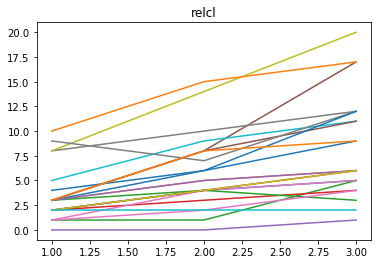

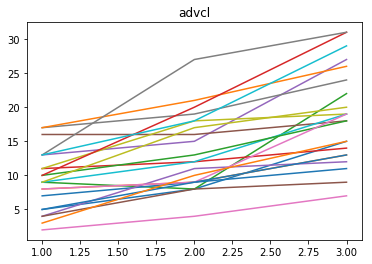

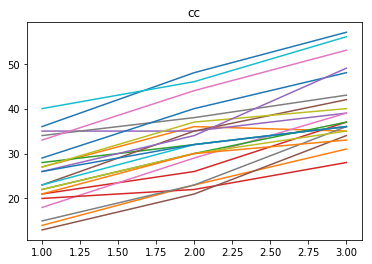

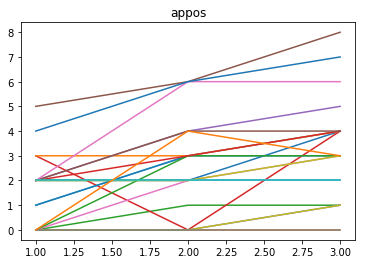

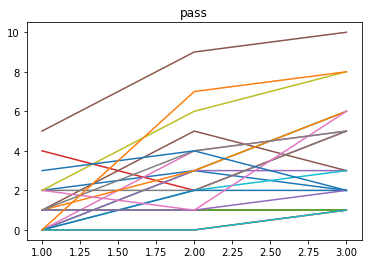

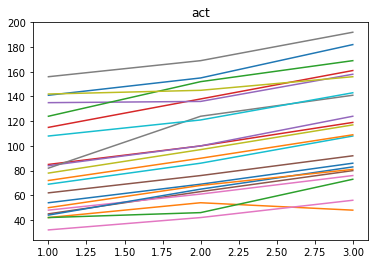

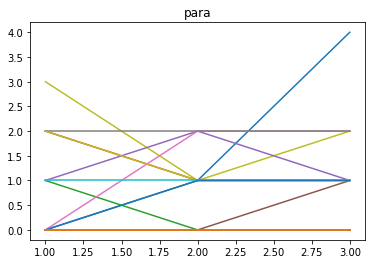

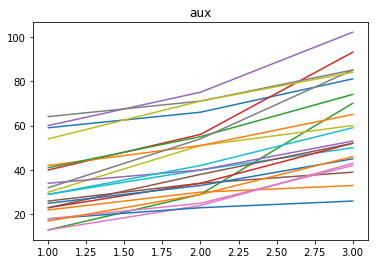

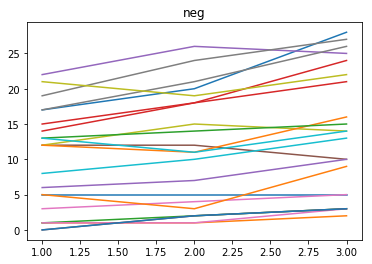

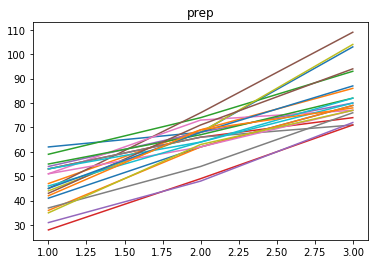

In [22]:
cols = list(df_brit)
cols.remove('article_name')
cols.remove('cleaned1')
cols.remove('cleaned2')
cols.remove('cleaned3')
cols.remove('dep1')
cols.remove('dep2')
cols.remove('dep3')

for idx in range(0,len(cols),3):
    x1 = cols[idx]
    x2 = cols[idx+1]
    x3 = cols[idx+2]
    plot_level(df_brit, [x1, x2, x3], cols[idx][5:])